In [1]:
!kaggle datasets download -d  harishvutukuri/dogs-vs-wolves -p ../../data

dogs-vs-wolves.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip -q -u ../../data/dogs-vs-wolves.zip -d ../../data/dogs-vs-wolves

## Imports

In [3]:
import os

# Torch #
import torch
from torch import nn, optim
from torch.utils.data import DataLoader 

# Torchvision #
from torchvision import datasets, transforms, models

# Torchero #
import torchero
from torchero import SupervisedTrainer # Training the model
from torchero.callbacks import ProgbarLogger # Model supervising
from torchero.utils.data import train_test_split
from torchero.utils import show_imagegrid_dataset
from matplotlib import pyplot as plt

## Training dataset

In [4]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])

In [5]:
dataset = datasets.ImageFolder(root='../../data/dogs-vs-wolves/data', transform=transform)

In [6]:
train_ds, val_ds = train_test_split(dataset)

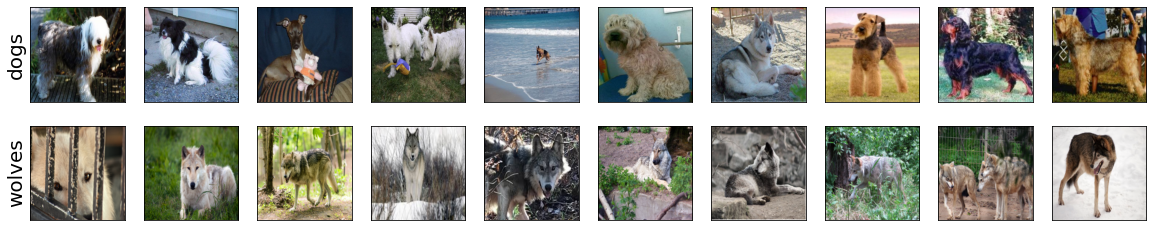

In [7]:
show_imagegrid_dataset(train_ds)

### Test dataset

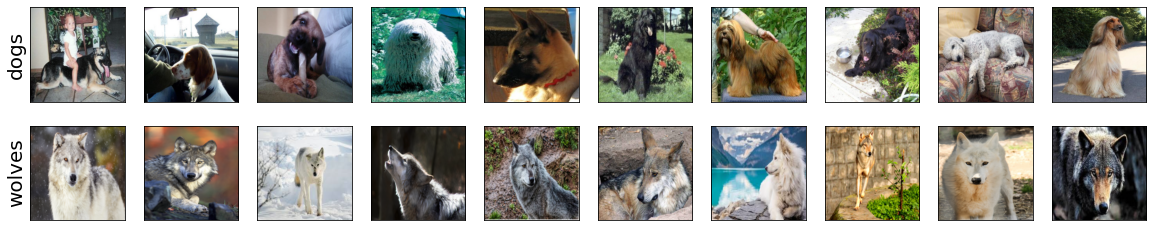

In [8]:
show_imagegrid_dataset(val_ds)

### DataLoader

In [9]:
train_dl = DataLoader(train_ds, batch_size=10, num_workers=6, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=10, num_workers=6)

## Define model

In [10]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.weight.shape[-1], 1)
    
    def forward(self, x):
        x = self.model(x)
        x = x.squeeze()
        return x

In [11]:
model = Network()

## Train model

In [12]:
trainer = SupervisedTrainer(model=model,
                            logging_frecuency=10,
                            optimizer='adam',
                            criterion='binary_cross_entropy_wl',
                            acc_meters=['recall_wl', 'precision_wl', 'binary_with_logits_accuracy', 'f1_wl'],
                            callbacks=[ProgbarLogger(notebook=True)])

In [13]:
trainer.cuda()

In [14]:
trainer.train(train_dl, val_dl, epochs=10)

### Training results

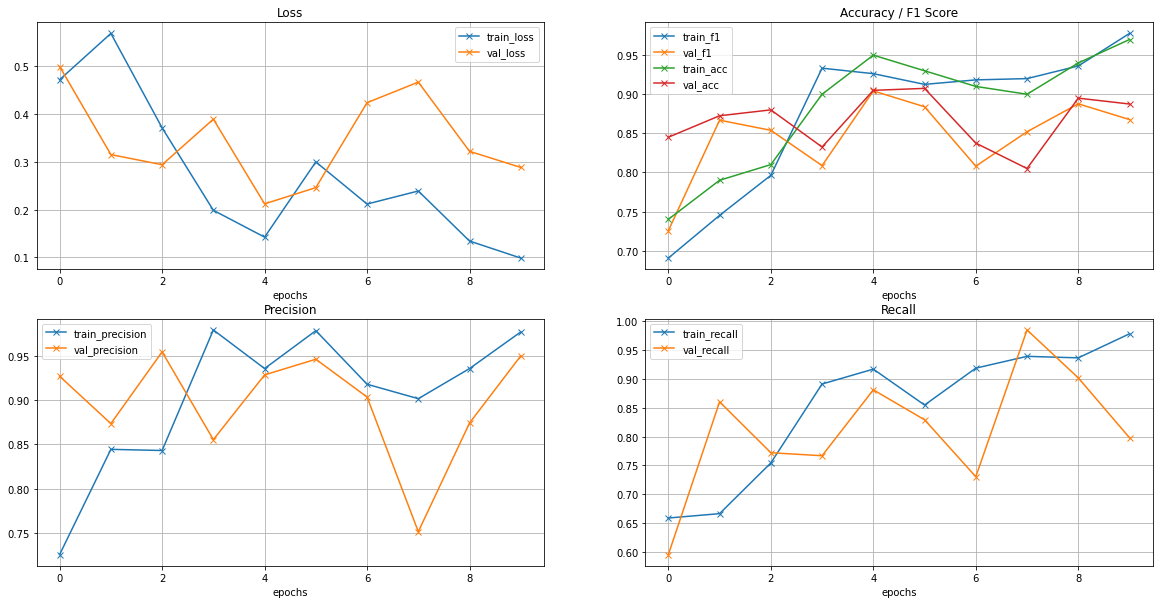

In [15]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
axs = axs.flatten()

trainer.history.epoch_plot(['train_loss', 'val_loss'], ax=axs[0], title="Loss")
trainer.history.epoch_plot(['train_f1', 'val_f1', 'train_acc', 'val_acc'], ax=axs[1], title="Accuracy / F1 Score")
trainer.history.epoch_plot(['train_precision', 'val_precision'], ax=axs[2], title="Precision")
trainer.history.epoch_plot(['train_recall', 'val_recall'], ax=axs[3], title="Recall")

plt.show()